# Fetal Cardiotocograph (CTG) Classification

#### Kate Stadelman

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import shap
%matplotlib inline


## Background & Purpose

Used during pregnancy to monitor fetal heart rate and uterine contractions, cardiotocography (CTG) tests “allow early detection of fetal distress” (Potter, 2021). Typically, CTGs are manually reviewed by obstetricians and midwives (Figure 1). One criticism of this diagnostic tool is the tendency for the same CTG to receive different interpretations depending on the reviewer (high inter-observer variability rate) (Prior & Lees, 2019). An automated, reliable method for reading CTGs would empower expectant mothers with the knowledge they need while also reducing burden on their clinical teams.

The purpose of this research project is to leverage machine learning to interpret CTGs. We explore feature extraction methods and classification algorithms in pursuit of our research question: How do Random Forest, Logistic Regression, and K-Nearest Neighbors compare in predicting normal vs. abnormal CTG results given test metrics?


## Data

This research project utilizes a dataset of 2,126 CTGs. Test measurements form 21 numeric input features related to uterine contractions, fetal movements, as well as several fetal heart rate metrics: baseline beats per minute, accelerations and decelerations, short- and long-term variability, and histogram descriptive statistics. Three expert obstetricians reviewed these CTGs, providing an output label of normal, suspect, or pathological for each test.

In [2]:
# Read in data, and display preview.
df = pd.read_csv('fetal_health.csv')
pd.set_option('display.max_columns', None)
df.sample(10)


,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
220,129,0.003,0.016,0.000,0.000,0.0,0.000,52,0.7,0,11.5,80,68,148,10,0,133,134,134,3,1,1
786,117,0.000,0.011,0.000,0.000,0.0,0.000,51,0.8,9,13.3,77,56,133,5,0,123,122,124,2,1,1
1375,121,0.007,0.000,0.010,0.004,0.0,0.000,21,1.9,0,2.9,83,74,157,2,0,125,123,126,19,0,1
1904,130,0.002,0.000,0.012,0.013,0.0,0.000,61,2.0,0,0.0,127,50,177,5,0,121,98,115,94,0,3
2111,136,0.000,0.004,0.009,0.009,0.0,0.002,63,2.2,0,1.9,86,67,153,6,0,134,112,123,71,1,1
211,125,0.003,0.010,0.000,0.000,0.0,0.000,51,0.6,0,4.9,16,125,141,1,0,133,132,134,0,0,1
59,144,0.008,0.000,0.007,0.000,0.0,0.000,33,1.1,0,6.2,100,78,178,5,0,149,152,152,8,1,1
1261,118,0.000,0.000,0.002,0.002,0.0,0.000,24,1.5,0,9.7,55,89,144,1,1,125,118,121,10,0,1
171,116,0.000,0.000,0.005,0.000,0.0,0.000,48,0.6,26,5.5,12,114,126,1,0,120,120,122,0,0,1
1825,140,0.000,0.002,0.004,0.008,0.0,0.000,62,1.4,0,4.9,93,66,159,5,1,142,134,144,30,1,1


In [3]:
df.shape

(2126, 22)

## Exploratory Data Analysis & Visualization

During the data preprocessing phase, we confirm the dataset has no missing values, as well as generated descriptive statistics for each input variable. The distribution of output classifications was visually inspected. Due to extreme imbalance, suspect and pathological CTGs were mapped to a single abnormal class, Class 1, and normal CTGs were mapped to Class 0. While improved, the final output classes still suffer from imbalance. For every input variable, boxplots were created to identify features with significant outliers, and histograms were used to visualize feature distributions to determine the most appropriate scaler. After scaling, a correlation heatmap was produced to uncover highly correlated features that might negatively impact Logistic Regression.

### Missing Data

In [4]:
# Check data types and missing value counts.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline_value                                          2126 non-null   int64  
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   int64  
 8   mean_value_of_short_term_variability  

### Descriptive Statistics

In [5]:
# Descriptive Statistics.
df.describe()


,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


### Target Balance/Imbalance

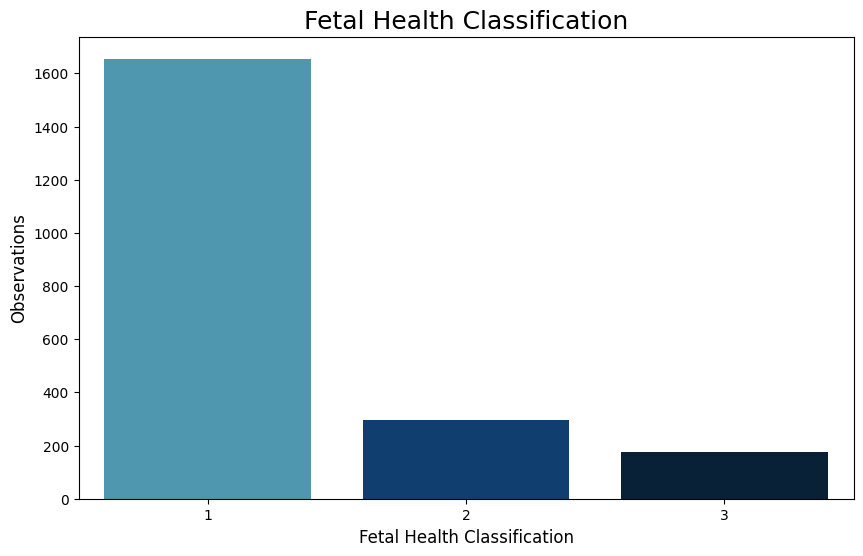

In [6]:
# Check balance of target variable.
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='fetal_health', palette='ocean_r')
plt.title('Fetal Health Classification', fontsize=18)
plt.xlabel('Fetal Health Classification', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.show()


In [7]:
# Given the imbalanced nature of the data, as well as the extremely small number of class 3 observations,
# we create a new target variable of 0 = Normal and 1 = Suspect/Pathological.

df['target'] = df.fetal_health.apply(lambda x: 0 if x == 1 else 1)
df.drop(columns=['fetal_health'], inplace=True)


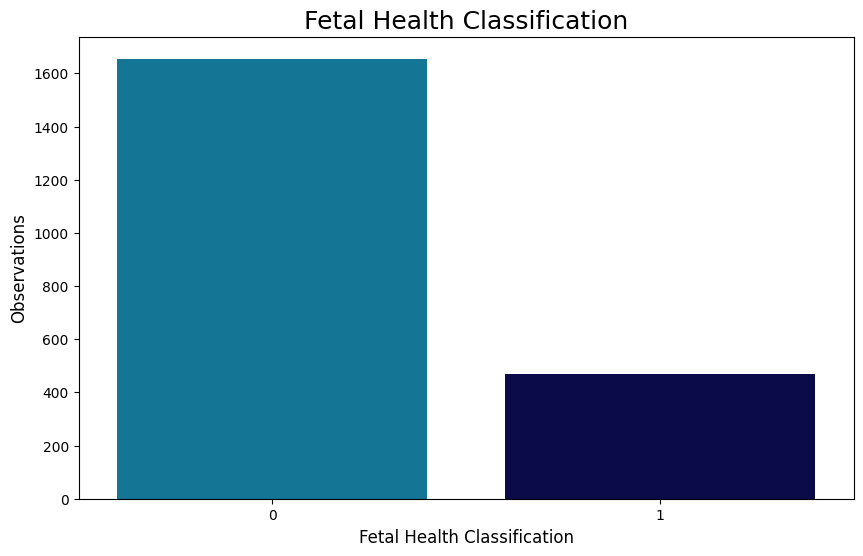

In [8]:
# Check balance of mapped target variable.
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='target', palette='ocean_r')
plt.title('Fetal Health Classification', fontsize=18)
plt.xlabel('Fetal Health Classification', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.show()


## Feature Extraction

Outliers were identified and removed using the interquartile range method, leaving 1,349 observations. Additionally, all input variables were scaled using min-max normalization.  Due to several highly correlated features, principal component analysis was performed. Seven principal components were extracted from the original 21 features, maintaining 99.2% of the explained variance. These seven principal components were mapped back to their most correlated feature for later analysis of feature importance. To complete data preprocessing, the final dataset was randomly split into training (70%) and test (30%) sets.

### Outliers

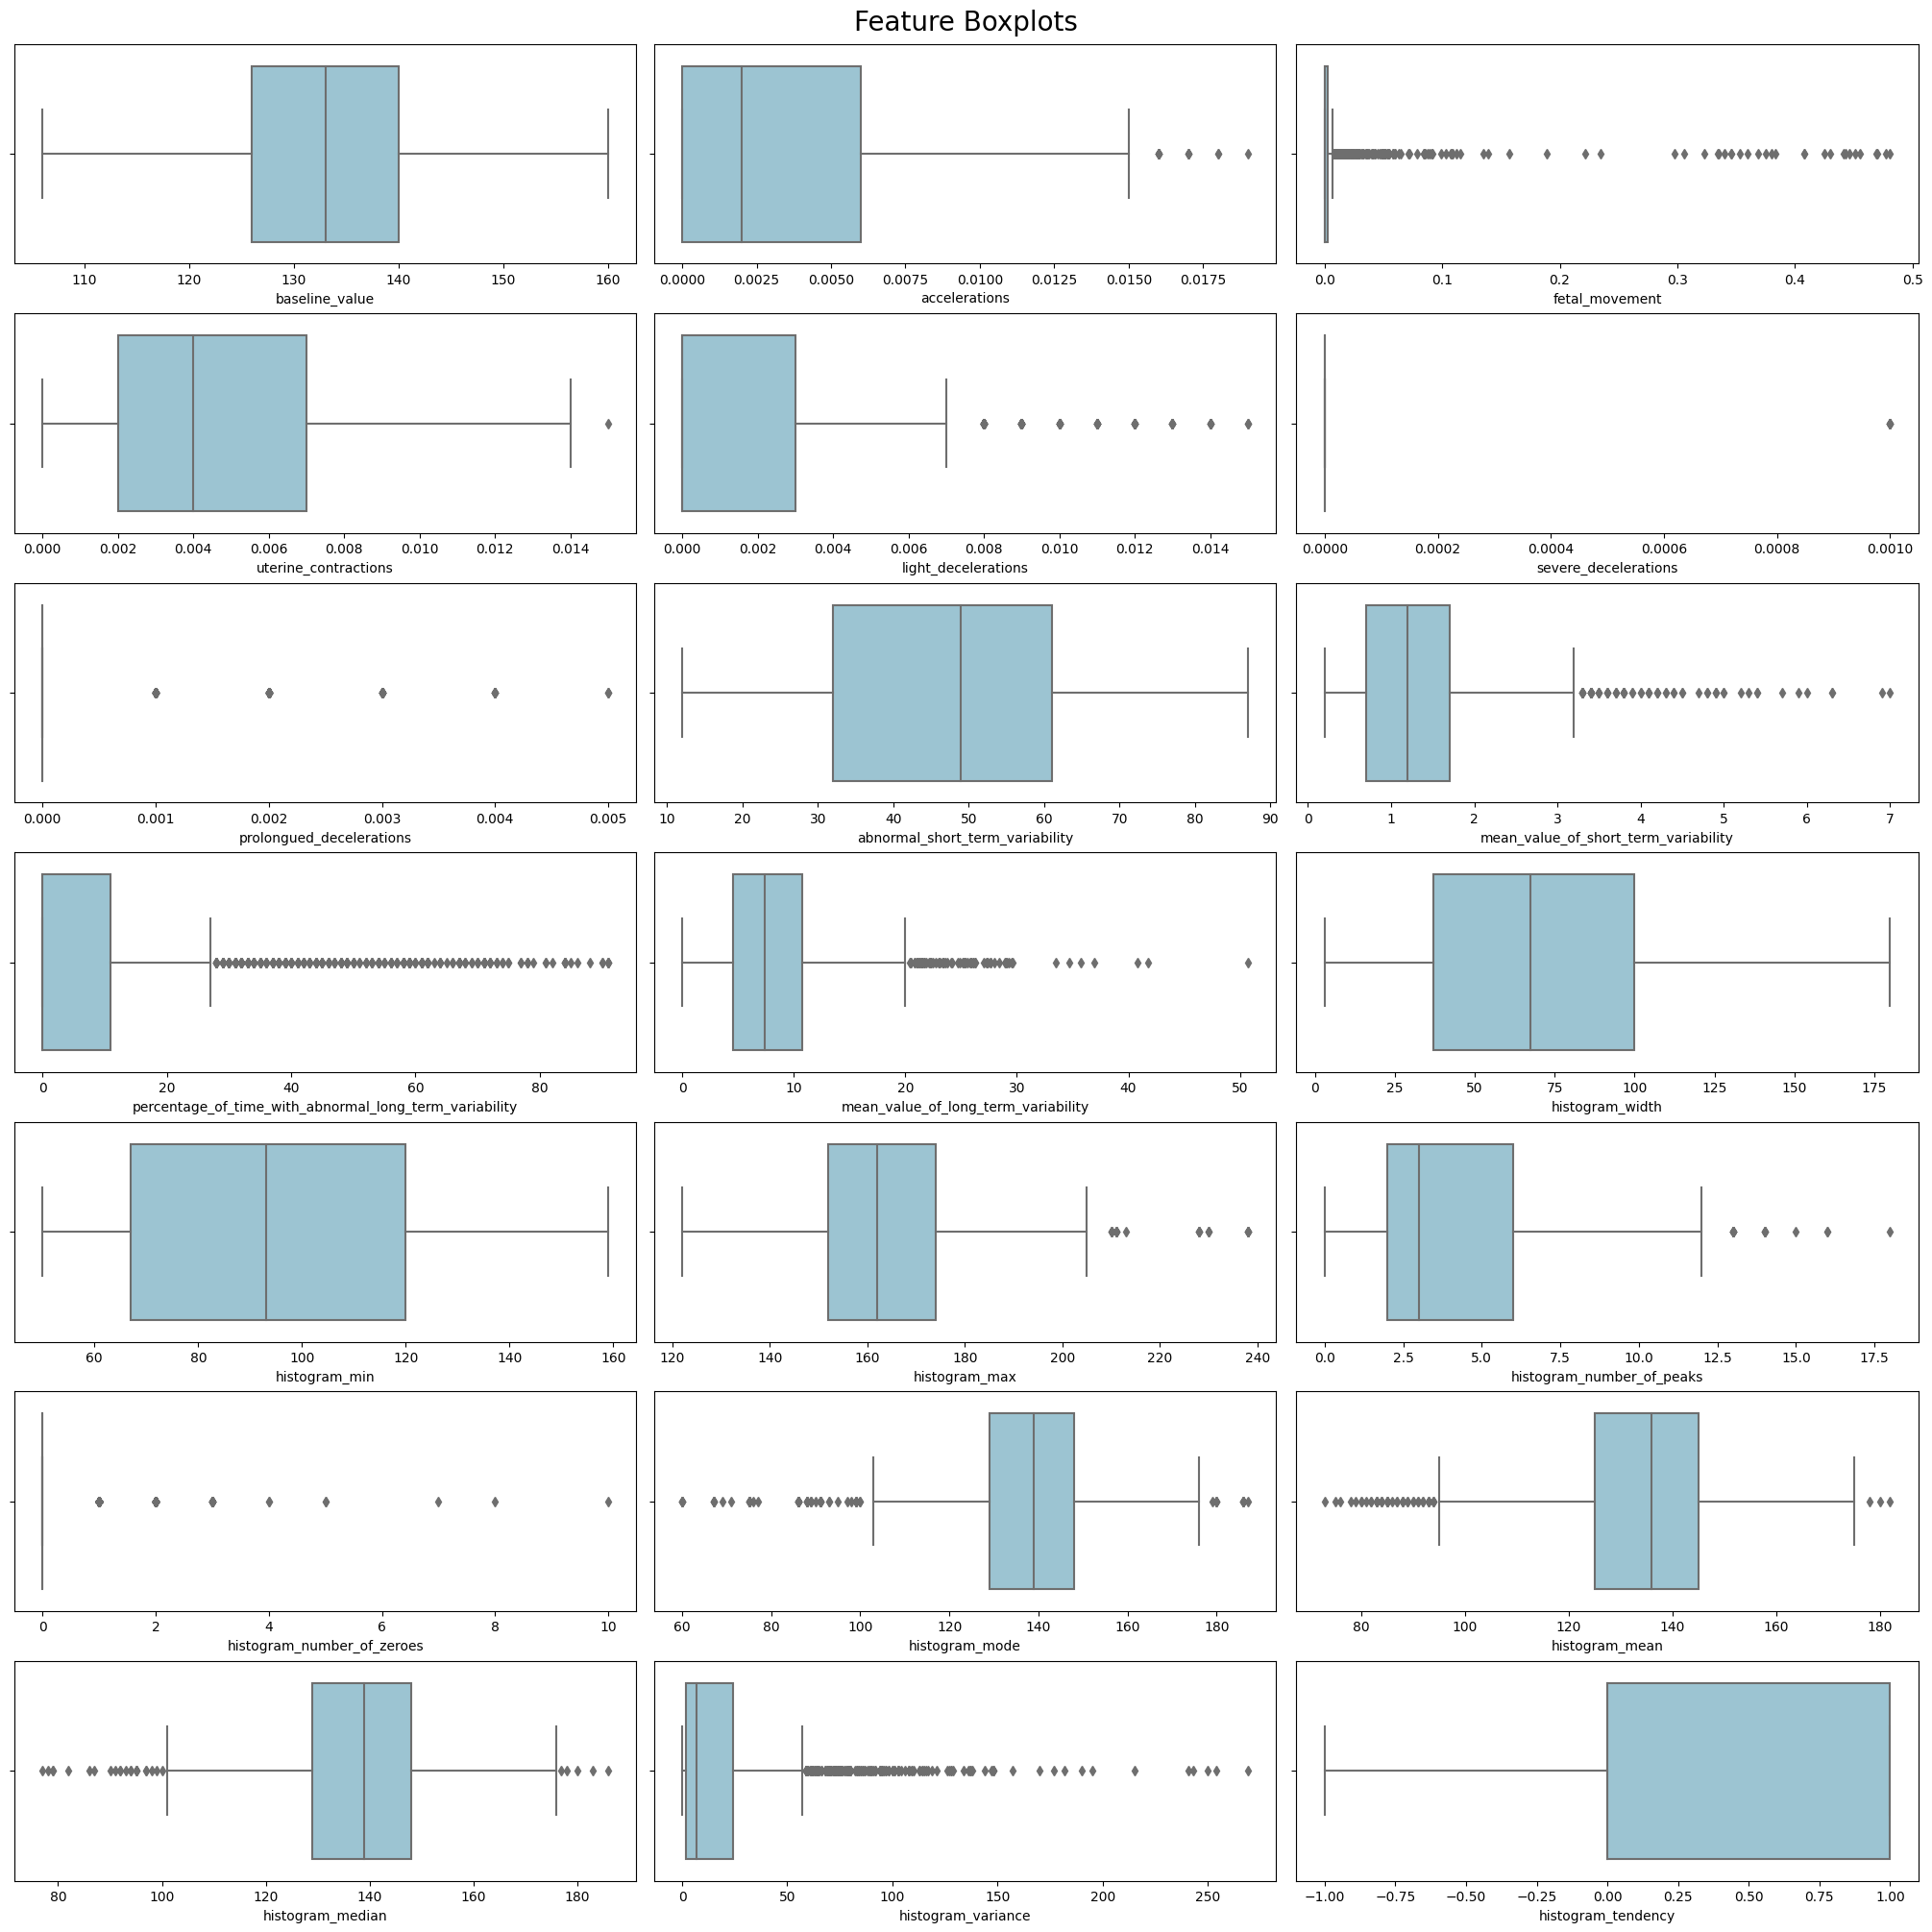

In [9]:
# Feature boxplots.
features = df.columns[:-1]
l,w = 7,3
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(20,20))
fig.suptitle('Feature Boxplots', fontsize=20)
for i in range(len(features)):
    j,k = plots[i]
    sns.boxplot(x=features[i], data=df, ax=axs[j,k], color='#93c9db')
plt.show()


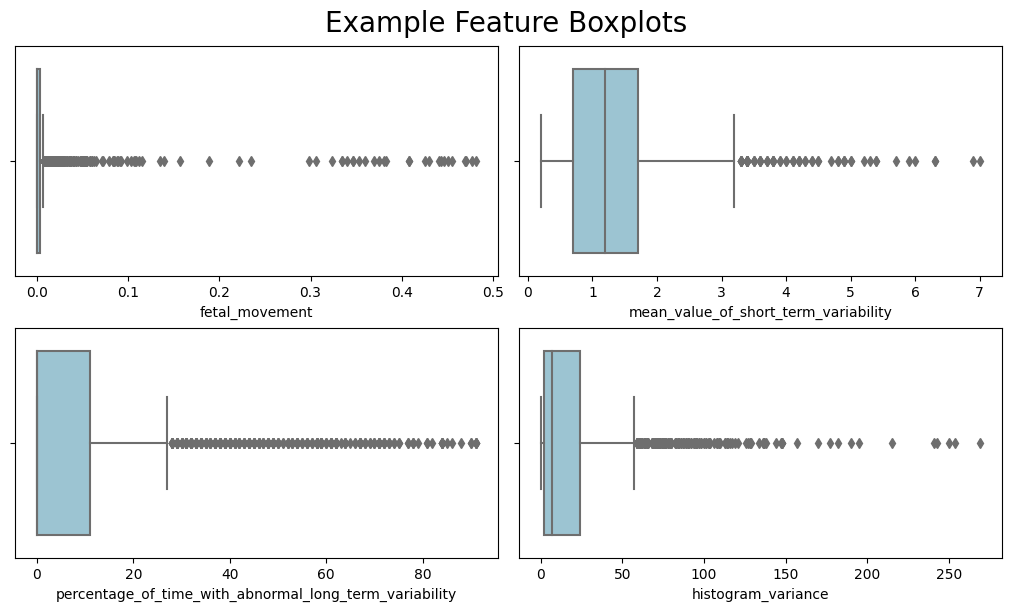

In [10]:
# Feature boxplots.
outliers = ['fetal_movement','mean_value_of_short_term_variability','percentage_of_time_with_abnormal_long_term_variability','histogram_variance']
l,w = 2,2
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(10,6))
fig.suptitle('Example Feature Boxplots', fontsize=20)
for i in range(len(outliers)):
    j,k = plots[i]
    sns.boxplot(x=outliers[i], data=df[outliers], ax=axs[j,k], color='#93c9db')
plt.show()


In [11]:
print(sns.color_palette("ocean_r").as_hex())

['#93c9db', '#2492b6', '#005b92', '#00246d', '#001249', '#004924']


In [12]:
# For each variable, remove values below Q1 - 1.5*IQR and values above Q3 + 1.5*IQR as outliers.
def tag_non_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    cutoff_below = q1 - (1.5 * iqr)
    cutoff_above = q3 + (1.5 * iqr)
    return df[col].apply(lambda x: x <= cutoff_above and x >= cutoff_below)

# Certain features contain a disproportionate number of outliers. If we include these features and remove
# outliers, it cuts the dataset in half. We drop these features.
include_cols = set(df.columns[:-1])
include_cols.remove('fetal_movement')
include_cols.remove('histogram_number_of_zeroes')

df_not_outliers = pd.DataFrame()
for column in include_cols:
    df_not_outliers[column] = tag_non_outliers(df, column)
df_not_outliers['true_cnt'] = df_not_outliers.sum(axis=1)

clean_df = df[df_not_outliers.true_cnt == len(include_cols)].copy()
clean_df.drop(columns=list(set(df.columns[:-1]).difference(include_cols)), inplace=True)

print('Observations prior to removal of outliers:', df.shape[0])
print('Observations after removal of outliers:', clean_df.shape[0])


Observations prior to removal of outliers: 2126
Observations after removal of outliers: 1349


### Data Distributions

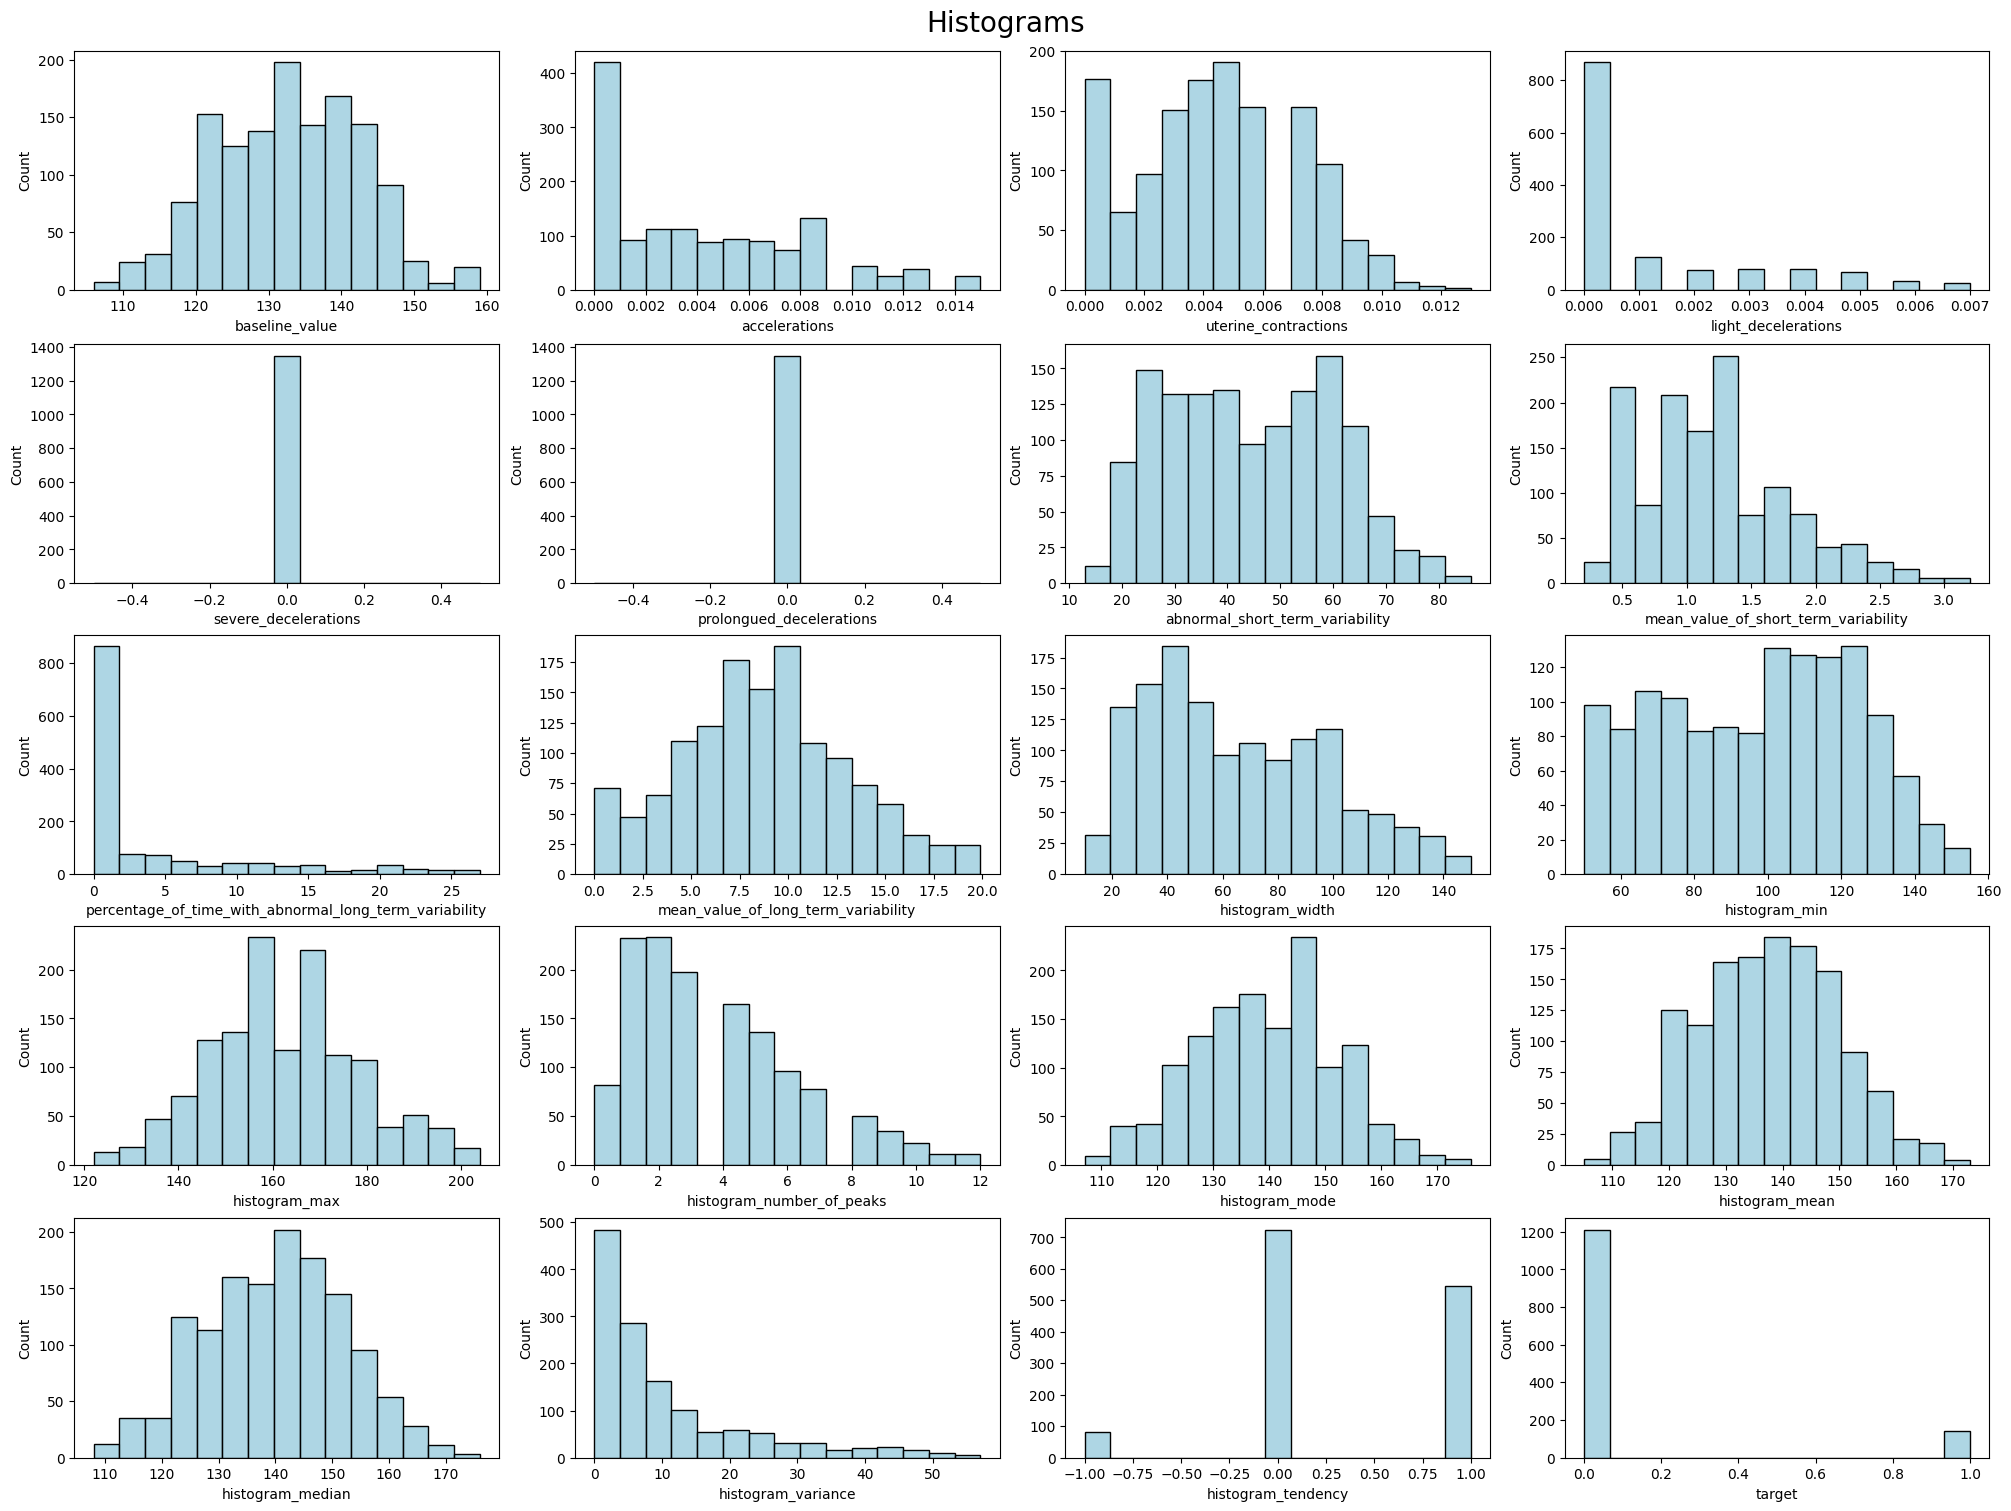

In [13]:
# Histograms.
l,w = 5,4
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(20,15))
fig.suptitle('Histograms', fontsize=20)
for i in range(len(clean_df.columns)):
    j,k = plots[i]
    sns.histplot(x=clean_df.columns[i], data=clean_df, bins=15, ax=axs[j,k], color='#93c9db')
plt.show()


In [14]:
# After removal of outliers, two columns have only a single value. These are removed.
clean_df.drop(columns=['severe_decelerations','prolongued_decelerations'], inplace=True)


### Data Transformation

In [15]:
# Scale data with MinMaxScaler to retain variance.
minmax = MinMaxScaler()
scaled_df = clean_df.copy()
scaled_df[clean_df.columns[:-1]] = minmax.fit_transform(scaled_df[clean_df.columns[:-1]])
scaled_df.head(10)


,baseline_value,accelerations,uterine_contractions,light_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,target
1,0.490566,0.400000,0.461538,0.428571,0.054795,0.633333,0.000000,0.522613,0.857143,0.171429,0.926829,0.500000,0.492754,0.455882,0.470588,0.210526,0.5,0
2,0.509434,0.200000,0.615385,0.428571,0.041096,0.633333,0.000000,0.673367,0.857143,0.171429,0.926829,0.416667,0.492754,0.441176,0.441176,0.228070,0.5,0
4,0.490566,0.466667,0.615385,0.000000,0.041096,0.733333,0.000000,1.000000,0.764286,0.028571,0.585366,0.750000,0.434783,0.455882,0.441176,0.192982,1.0,0
7,0.301887,0.000000,0.000000,0.000000,0.958904,0.100000,0.222222,0.783920,0.414286,0.114286,0.097561,0.000000,0.217391,0.250000,0.220588,0.052632,1.0,1
8,0.301887,0.000000,0.153846,0.000000,0.972603,0.100000,0.185185,0.683417,0.414286,0.114286,0.097561,0.000000,0.217391,0.250000,0.220588,0.052632,1.0,1
9,0.301887,0.000000,0.230769,0.000000,1.000000,0.033333,0.222222,0.532663,0.414286,0.114286,0.097561,0.083333,0.217391,0.250000,0.220588,0.017544,1.0,1
12,0.471698,0.333333,0.615385,0.428571,0.205479,0.400000,0.000000,0.648241,0.400000,0.361905,0.390244,0.416667,0.405797,0.426471,0.426471,0.122807,1.0,0
13,0.471698,0.600000,0.461538,0.285714,0.205479,0.433333,0.000000,0.271357,0.550000,0.200000,0.439024,0.166667,0.492754,0.470588,0.485294,0.175439,1.0,0
23,0.415094,0.000000,0.000000,0.000000,0.917808,0.100000,0.000000,0.341709,0.042857,0.609524,0.097561,0.000000,0.275362,0.279412,0.250000,0.017544,1.0,1
26,0.339623,0.000000,0.000000,0.000000,1.000000,0.066667,0.518519,0.241206,0.100000,0.685714,0.292683,0.083333,0.275362,0.308824,0.279412,0.000000,0.0,1


### Feature Correlation

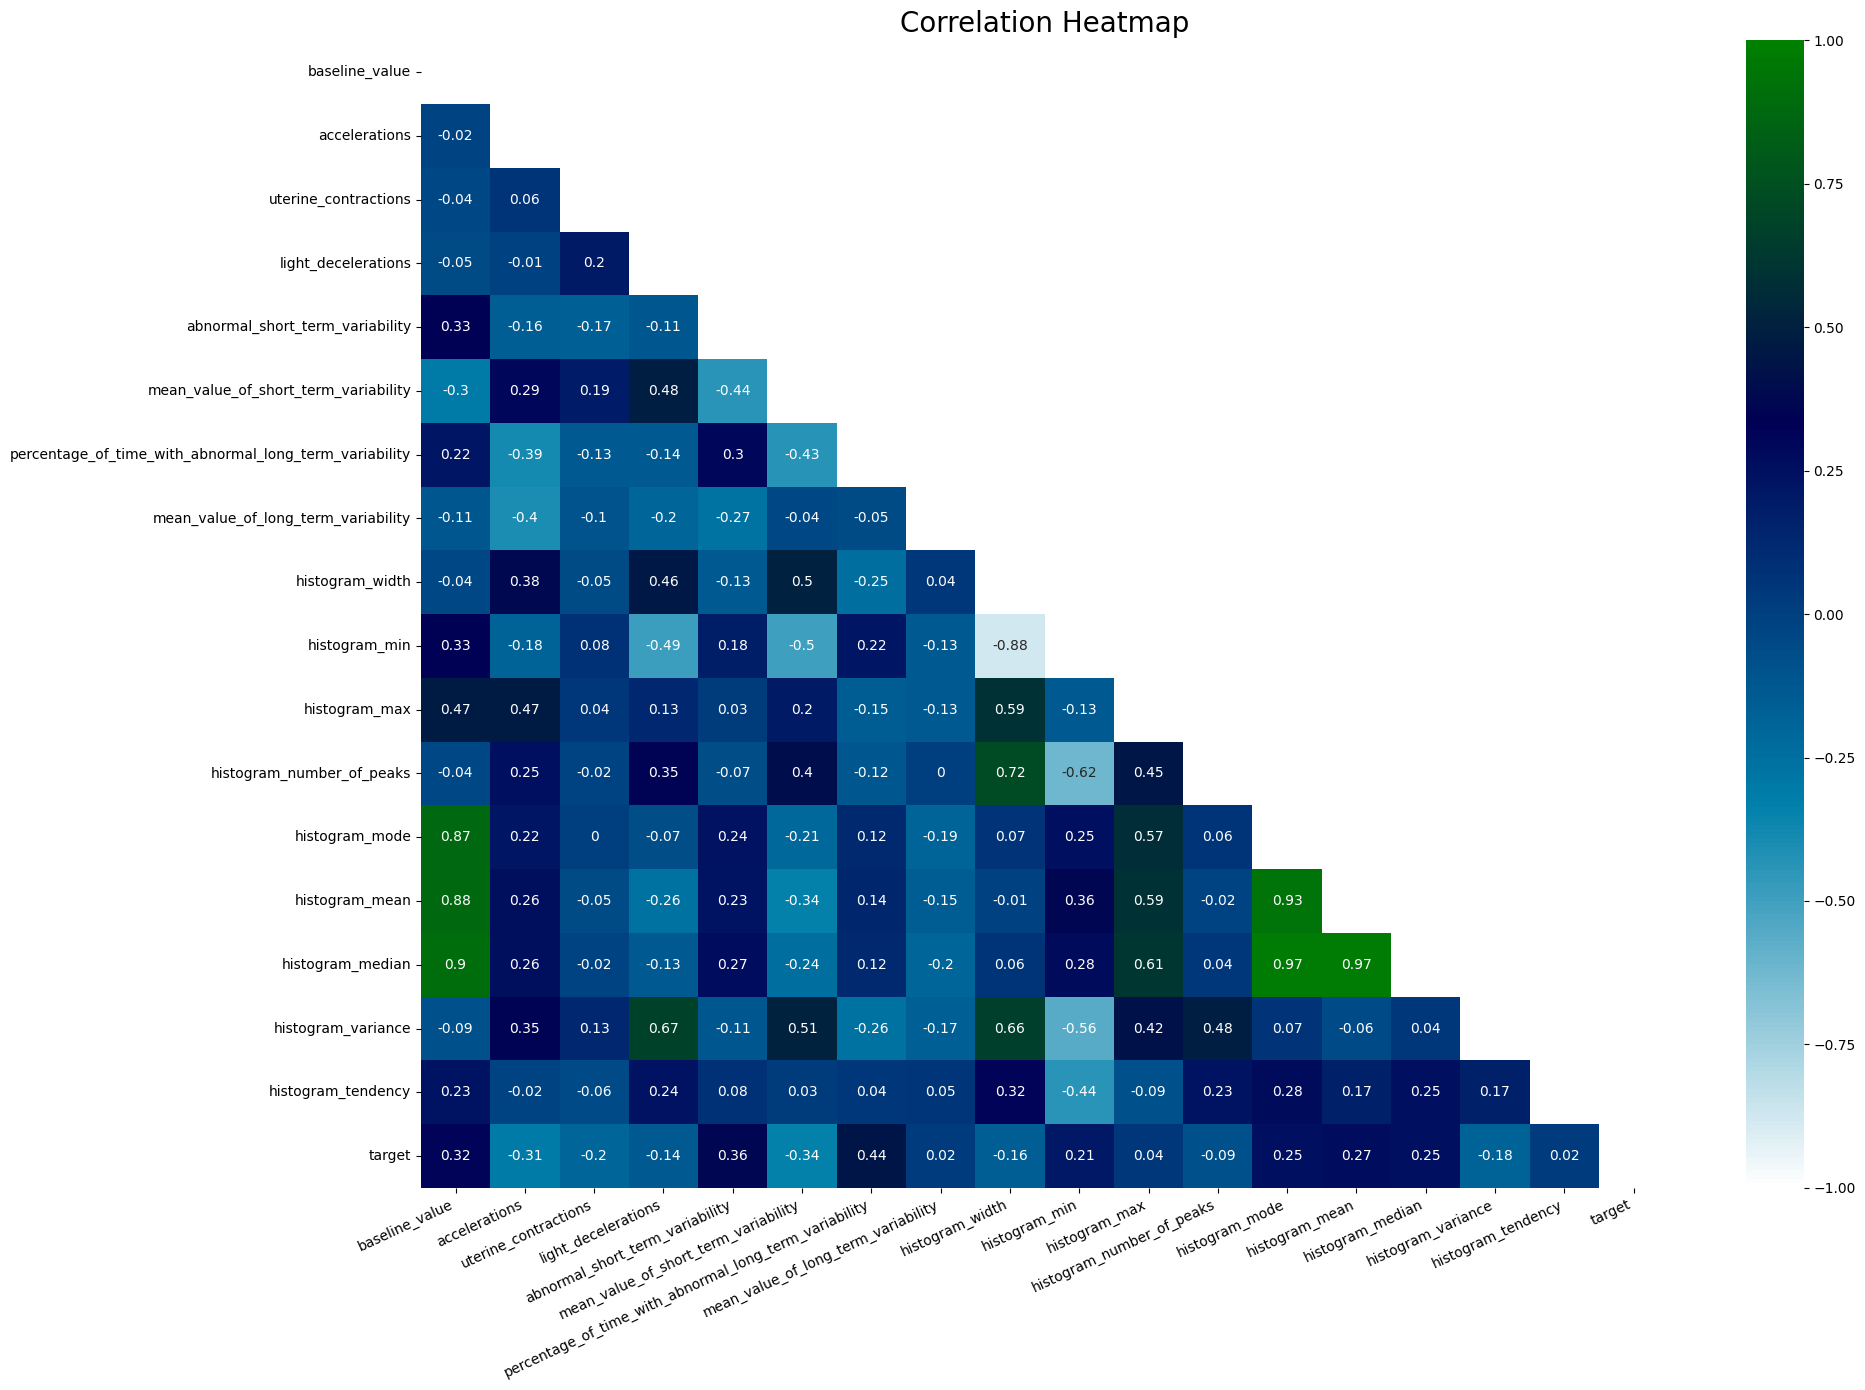

In [16]:
# Several features appear to be highly correlated to each other.
corr_matrix = clean_df.corr()
fig, ax = plt.subplots(figsize=(20,14))
mask = np.zeros_like(corr_matrix, dtype=bool)   # returns an array of False values with same shape as corr dataframe
mask[np.triu_indices_from(mask)] = True  # creates a boolean mask by making half the zero values == True
ax = sns.heatmap(corr_matrix.round(2), mask=mask, ax=ax, annot=True, vmin=-1, vmax=1, annot_kws={'fontsize':10}, cmap='ocean_r')
ax.set_xticklabels(ax.xaxis.get_ticklabels())
ax.set_yticklabels(ax.yaxis.get_ticklabels())
plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()


In [17]:
# Define arrays for remainder of analysis.
X = clean_df.drop('target', axis=1)
y = clean_df['target'].copy()


In [18]:
sns.color_palette('ocean_r').as_hex()

['#93c9db', '#2492b6', '#005b92', '#00246d', '#001249', '#004924']

In [19]:
print(sns.color_palette('ocean_r').as_hex())

['#93c9db', '#2492b6', '#005b92', '#00246d', '#001249', '#004924']


### PCA

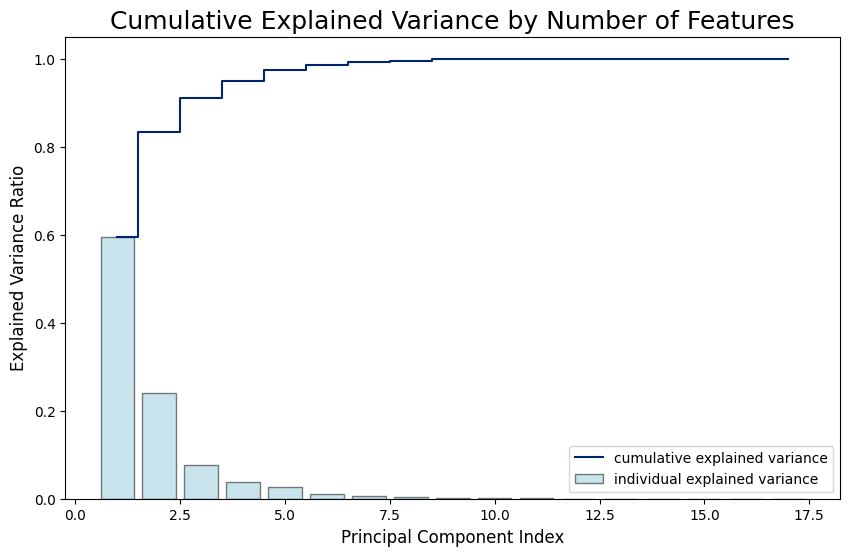

In [20]:
# Compute covariance matrix, and visualize cumulative sum of explained variances to choose right number of PCA dimensions.
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Calculate cumulative sum of explained variances.
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Plot explained variances
plt.figure(figsize=(10,6))
plt.bar(range(1,18), var_exp, alpha=0.5, align='center', label='individual explained variance', color='#93c9db', edgecolor = 'black')
plt.step(range(1,18), cum_var_exp, where='mid', label='cumulative explained variance', color='#00246d')
plt.title('Cumulative Explained Variance by Number of Features', fontsize=18)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xlabel('Principal Component Index', fontsize=12)
plt.legend(loc='best')
plt.show()


In [21]:
# 99% of the variance is explained with seven components.
print(f'Cumulative explained variance from PCA components: {cum_var_exp[6]:.3f}.')
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)


Cumulative explained variance from PCA components: 0.992.


In [22]:
# Let's try to understand how principal components are related to our features.
pca_features = pd.DataFrame(pca.components_,columns=clean_df.columns[:-1], 
                            index=[1,2,3,4,5,6,7]).reset_index()
pca_features.rename(columns={'index':'PC'}, inplace=True)
pca_features


,PC,baseline_value,accelerations,uterine_contractions,light_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,1,-0.034825,0.000031,-2.741036e-06,0.000022,-0.067018,0.007306,-0.041675,0.006414,0.761092,-0.584469,0.176623,0.044225,-0.011799,-0.037211,-0.016135,0.191419,0.004795
1,2,0.319220,0.000041,-9.633906e-07,-0.000007,0.186990,-0.004432,0.025467,-0.035264,0.168193,0.278767,0.446960,0.010603,0.434026,0.422785,0.431663,0.043278,0.002084
2,3,0.056474,-0.000064,-3.821224e-05,0.000001,0.932674,-0.012459,0.141991,-0.053327,-0.009598,-0.215900,-0.225498,0.002804,-0.014917,-0.051627,-0.010949,-0.055761,0.009518
3,4,-0.266322,0.000072,3.542958e-05,0.000020,0.258316,0.009174,-0.124557,-0.098960,0.095694,0.430354,0.526048,0.017238,-0.310464,-0.247168,-0.258979,0.373868,-0.035229
4,5,0.034921,0.000036,5.475919e-05,0.000099,-0.039318,0.010474,-0.074471,-0.134430,-0.215663,-0.092374,-0.308037,-0.015629,0.226228,0.002155,0.130993,0.868728,0.017366
5,6,0.060244,-0.000171,-1.494725e-05,0.000032,-0.118732,-0.010977,0.970082,-0.010176,0.024763,0.050275,0.075039,0.034658,-0.055952,-0.057781,-0.072961,0.138494,-0.006662
6,7,-0.536323,0.000463,2.472953e-05,-0.000050,-0.037780,0.004490,0.073028,-0.785113,0.012387,-0.035275,-0.022888,0.024814,0.175066,0.092733,0.135821,-0.170114,0.001697


In [23]:
# Find lables for principal components
principal_components = [pca_features.columns[1:][np.argmax(abs(pca_features[pca_features.columns[1:]][ pca_features['PC'] == i + 1 ]))] for i in range(7)]
principal_components[1] = 'histogram_mode'      ## Very close tie between histogram_max / histogram_mode, so leaving PC-4 as histogram_max
principal_components


['histogram_width',
 'histogram_mode',
 'abnormal_short_term_variability',
 'histogram_max',
 'histogram_variance',
 'percentage_of_time_with_abnormal_long_term_variability',
 'mean_value_of_long_term_variability']

### Data Splitting

In [24]:
# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=36)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(944, 7) (944,)
(405, 7) (405,)


## Model Building and Optimization

Initial Random Forest, Logistic Regression, and K-Nearest Neighbor models were constructed, and baseline scores were generated for both training and test datasets.  Like other medical diagnostic tools, false negatives are far more harmful than false positives, as false negatives prevent patients from receiving the care they need. Because of this, we placed far more emphasis on recall and ROC AUC scores during model evaluation. Prior to tuning, Random Forest was quite overfitted, and all three models had low recall scores for test data.

For hyperparameter tuning, we utilized grid search k-fold cross-validation. Max depth and out-of-bag scoring eliminated Random Forest overfitting. Lasso regularization was applied to Logistic Regression, and the number of neighbors, leaf size, and distance metric parameters were tuned for K-Nearest Neighbors. Of the many parameters tested, class weight had the greatest impact for both Random Forest and Logistic Regression in improving model outcomes.

In [25]:
# Random Forest
rf_clf = RandomForestClassifier(random_state=36)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=36)

In [26]:
# Logistic Regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=36)
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=36)

In [27]:
# K-Nearest Neighbors
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)


KNeighborsClassifier()

In [28]:
models = [ rf_clf, log_reg, knn_clf ]

table_train = PrettyTable()
table_test = PrettyTable()
fields = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
table_train.field_names = fields
table_test.field_names = fields

for model in models:
    # Training metrics.
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    roc_train = roc_auc_score(y_train, y_pred_train)
    table_train.add_row([type(model).__name__, format(accuracy_train, '.3f'), format(precision_train, '.3f'), format(recall_train,'.3f'), 
                         format(f1_train,'.3f'), format(roc_train,'.3f')])
    
    # Test metrics.
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_test = roc_auc_score(y_test, y_pred_test)
    table_test.add_row([type(model).__name__, format(accuracy_test, '.3f'), format(precision_test, '.3f'), format(recall_test,'.3f'), 
                         format(f1_test,'.3f'), format(roc_test,'.3f')])
    

print('BASELINE SCORES FOR TRAINING DATA')
print(table_train)
print('\n\nBASELINE SCORES FOR TEST DATA')
print(table_test)

BASELINE SCORES FOR TRAINING DATA
+------------------------+----------+-----------+--------+----------+---------+
|         Model          | Accuracy | Precision | Recall | F1 Score | ROC AUC |
+------------------------+----------+-----------+--------+----------+---------+
| RandomForestClassifier |  1.000   |   1.000   | 1.000  |  1.000   |  1.000  |
|   LogisticRegression   |  0.912   |   0.647   | 0.427  |  0.515   |  0.699  |
|  KNeighborsClassifier  |  0.932   |   0.767   | 0.544  |  0.636   |  0.762  |
+------------------------+----------+-----------+--------+----------+---------+


BASELINE SCORES FOR TEST DATA
+------------------------+----------+-----------+--------+----------+---------+
|         Model          | Accuracy | Precision | Recall | F1 Score | ROC AUC |
+------------------------+----------+-----------+--------+----------+---------+
| RandomForestClassifier |  0.948   |   0.759   | 0.611  |  0.677   |  0.796  |
|   LogisticRegression   |  0.928   |   0.630   | 0.47

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

In [30]:
# Logistic Regression ROC Curve Data
preds_lr = cross_val_predict(log_reg, X_train, y_train, cv=3, method='predict_proba')
scores_lr = preds_lr[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, scores_lr)

# KNN ROC Curve Data
preds_knn = cross_val_predict(knn_clf, X_train, y_train, cv=3, method='predict_proba')
scores_knn = preds_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, scores_knn)

# Random Forest ROC Curve Data
preds_rf = cross_val_predict(rf_clf, X_train, y_train, cv=3, method='predict_proba')
scores_rf = preds_rf[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, scores_rf)


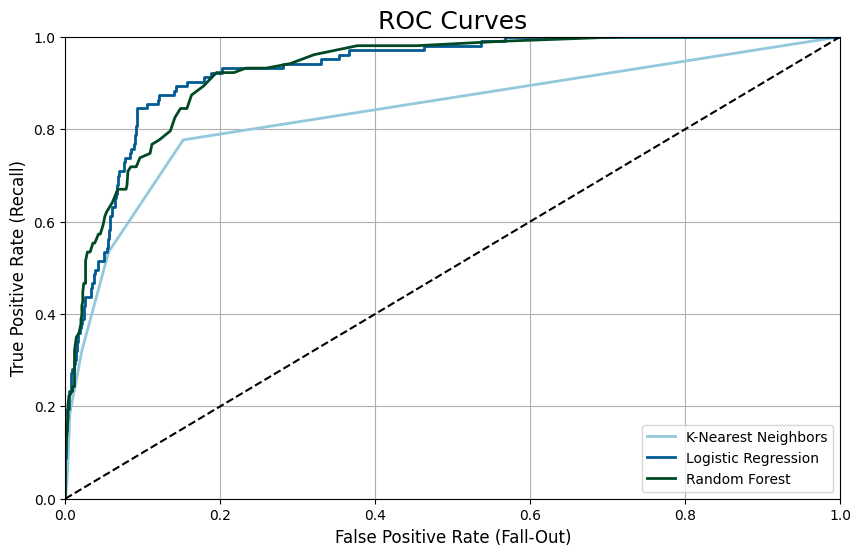

In [31]:
# ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, linewidth=2, label='K-Nearest Neighbors', color='#93c9db')
plt.plot(fpr_lr, tpr_lr, linewidth=2, label='Logistic Regression', color='#005b92')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label='Random Forest', color='#004924')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.title('ROC Curves', fontsize=18)
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.grid(True)   
plt.legend(loc='lower right')
plt.show()


### Hyperparameter Tuning


#### Random Forest

In [32]:
# Random Forest
rf = RandomForestClassifier(random_state=36)
rf_pg = {
    'n_estimators': [50, 70, 100],
    'max_depth': [2, 3, 5],
    'oob_score': [True, False],
    'class_weight': [{0:.09, 1:.91}, {0:.1, 1:.9}]
}
rf_grid = GridSearchCV(rf, param_grid=rf_pg, cv=10, scoring='recall')
with joblib.parallel_backend('threading', n_jobs=4):
    rf_grid.fit(X_train, y_train)

# Print best parameters.
rf_grid.best_params_


{'class_weight': {0: 0.09, 1: 0.91},
 'max_depth': 2,
 'n_estimators': 100,
 'oob_score': True}

In [33]:
# Use best model to find new metrics.
rf_final = rf_grid.best_estimator_
rf_final.fit(X_train, y_train)
print('Random Forest Classification Report:')
print(classification_report(y_train, rf_final.predict(X_train)))
print(f'ROC AUC: {roc_auc_score(y_train, rf_final.predict(X_train)):.3f}')


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       841
           1       0.43      0.91      0.58       103

    accuracy                           0.86       944
   macro avg       0.71      0.88      0.75       944
weighted avg       0.93      0.86      0.88       944

ROC AUC: 0.881


#### Logistic Regression 

In [34]:
# Logistic Regression GridSearchCV
lr = LogisticRegression(max_iter=5000, random_state=36)
lr_pg = {
    'penalty': ['l1','l2'], 
    'solver': ['liblinear','saga'], 
    'class_weight': [{0:.01, 1:.99}, {0:.1, 1:.9}, {0:.15, 1:.85}], 
    'C': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1] 
}
lr_grid = GridSearchCV(lr, param_grid=lr_pg, cv=10, scoring='roc_auc')
lr_grid.fit(X_train, y_train)

# Print best parameters.
lr_grid.best_params_

{'C': 1,
 'class_weight': {0: 0.15, 1: 0.85},
 'penalty': 'l2',
 'solver': 'liblinear'}

In [35]:
# Use best model to find new metrics.
lr_final = lr_grid.best_estimator_
lr_final.fit(X_train, y_train)
print('Logistic Regression Classification Report:')
print(classification_report(y_train, lr_final.predict(X_train)))
print(f'ROC AUC: {roc_auc_score(y_train, lr_final.predict(X_train)):.3f}')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       841
           1       0.48      0.87      0.62       103

    accuracy                           0.88       944
   macro avg       0.73      0.88      0.78       944
weighted avg       0.93      0.88      0.90       944

ROC AUC: 0.880


#### K-Nearest Neighbors

In [36]:
# KNN
knn = KNeighborsClassifier()
knn_pg = {
    'n_neighbors': [ i for i in range(5,15) ], 
    'leaf_size': [10,30,50], 
    'algorithm': ['ball_tree','kd_tree'], 
    'p': [1,2],
    'metric':['minkowski','chebyshev'] 
}
knn_grid = GridSearchCV(knn, param_grid=knn_pg, cv=10, scoring='recall')
with joblib.parallel_backend('threading', n_jobs=4):
    knn_grid.fit(X_train, y_train)

# Print best parameters.
knn_grid.best_params_


{'algorithm': 'ball_tree',
 'leaf_size': 10,
 'metric': 'minkowski',
 'n_neighbors': 5,
 'p': 1}

In [37]:
# Use best model to find new metrics.
knn_final = knn_grid.best_estimator_
knn_final.fit(X_train, y_train)
print('K-Nearest Neighbors Classification Report:')
print(classification_report(y_train, knn_final.predict(X_train)))
print(f'ROC AUC: {roc_auc_score(y_train, knn_final.predict(X_train)):.3f}')


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       841
           1       0.74      0.59      0.66       103

    accuracy                           0.93       944
   macro avg       0.85      0.78      0.81       944
weighted avg       0.93      0.93      0.93       944

ROC AUC: 0.784


Random Forest slightly edges out Logistic Regression for the best Recall for Class 1.

### ROC Curves

In [38]:
# Logistic Regression ROC Curve Data
preds_lr = cross_val_predict(lr_final, X_train, y_train, cv=3, method='predict_proba')
scores_lr = preds_lr[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, scores_lr)

# KNN ROC Curve Data
preds_knn = cross_val_predict(knn_final, X_train, y_train, cv=3, method='predict_proba')
scores_knn = preds_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, scores_knn)

# Random Forest ROC Curve Data
preds_rf = cross_val_predict(rf_final, X_train, y_train, cv=3, method='predict_proba')
scores_rf = preds_rf[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, scores_rf)

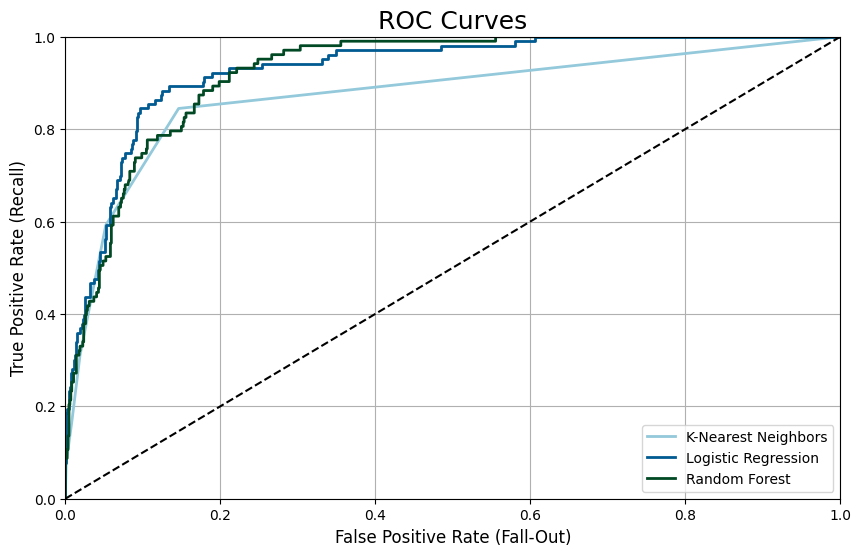

In [39]:
# ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, linewidth=2, label='K-Nearest Neighbors', color='#93c9db')
plt.plot(fpr_lr, tpr_lr, linewidth=2, label='Logistic Regression', color='#005b92')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label='Random Forest', color='#004924')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.title('ROC Curves', fontsize=18)
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.grid(True)   
plt.legend(loc='lower right')
plt.show()


## Model Comparison

Final models for Random Forest and Lasso Logistic Regression performed similarly, with Random Foresting achieving slightly higher recall and ROC AUC scores for both test and training. Tuning did not appear to improve K-Nearest Neighbors, which maintained high accuracy but ultimately had poor recall. In addition to scoring, comparison ROC curves (Figure 10) and confusion matrices were generated, confirming Random Forest as the best model with 94.4% recall and 89.5% ROC AUC on test data.

### Summary Tables


In [40]:
models = [ rf_final, lr_final, knn_final ]

table_train = PrettyTable()
table_test = PrettyTable()
fields = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
table_train.field_names = fields
table_test.field_names = fields

for model in models:
    model.fit(X_train, y_train)
    
    # Training metrics.
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    roc_train = roc_auc_score(y_train, y_pred_train)
    table_train.add_row([type(model).__name__, format(accuracy_train, '.3f'), format(precision_train, '.3f'), format(recall_train,'.3f'), 
                         format(f1_train,'.3f'), format(roc_train,'.3f')])
    
    # Test metrics.
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_test = roc_auc_score(y_test, y_pred_test)
    table_test.add_row([type(model).__name__, format(accuracy_test, '.3f'), format(precision_test, '.3f'), format(recall_test,'.3f'), 
                         format(f1_test,'.3f'), format(roc_test,'.3f')])
    

print('FINAL SCORES FOR TRAINING DATA')
print(table_train)
print('\n\nFINAL SCORES FOR TEST DATA')
print(table_test)


FINAL SCORES FOR TRAINING DATA
+------------------------+----------+-----------+--------+----------+---------+
|         Model          | Accuracy | Precision | Recall | F1 Score | ROC AUC |
+------------------------+----------+-----------+--------+----------+---------+
| RandomForestClassifier |  0.857   |   0.427   | 0.913  |  0.582   |  0.881  |
|   LogisticRegression   |  0.885   |   0.484   | 0.874  |  0.623   |  0.880  |
|  KNeighborsClassifier  |  0.933   |   0.744   | 0.592  |  0.659   |  0.784  |
+------------------------+----------+-----------+--------+----------+---------+


FINAL SCORES FOR TEST DATA
+------------------------+----------+-----------+--------+----------+---------+
|         Model          | Accuracy | Precision | Recall | F1 Score | ROC AUC |
+------------------------+----------+-----------+--------+----------+---------+
| RandomForestClassifier |  0.854   |   0.374   | 0.944  |  0.535   |  0.895  |
|   LogisticRegression   |  0.877   |   0.410   | 0.889  |  

### Confusion Matrices

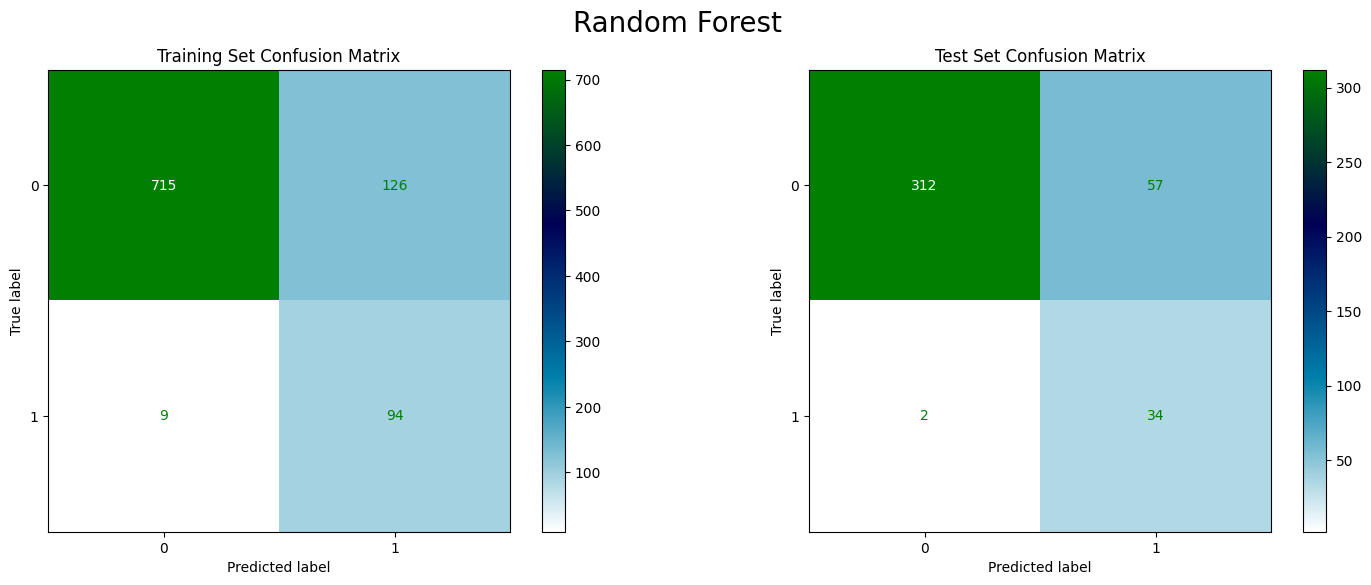

In [41]:
# Random Forest Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18,6))
ConfusionMatrixDisplay.from_estimator(rf_final, X_train, y_train, ax=axes[0], cmap='ocean_r')
axes[0].set_title('Training Set Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(rf_final, X_test, y_test, ax=axes[1], cmap='ocean_r')
axes[1].set_title('Test Set Confusion Matrix')
plt.suptitle('Random Forest', fontsize=20)
plt.show()



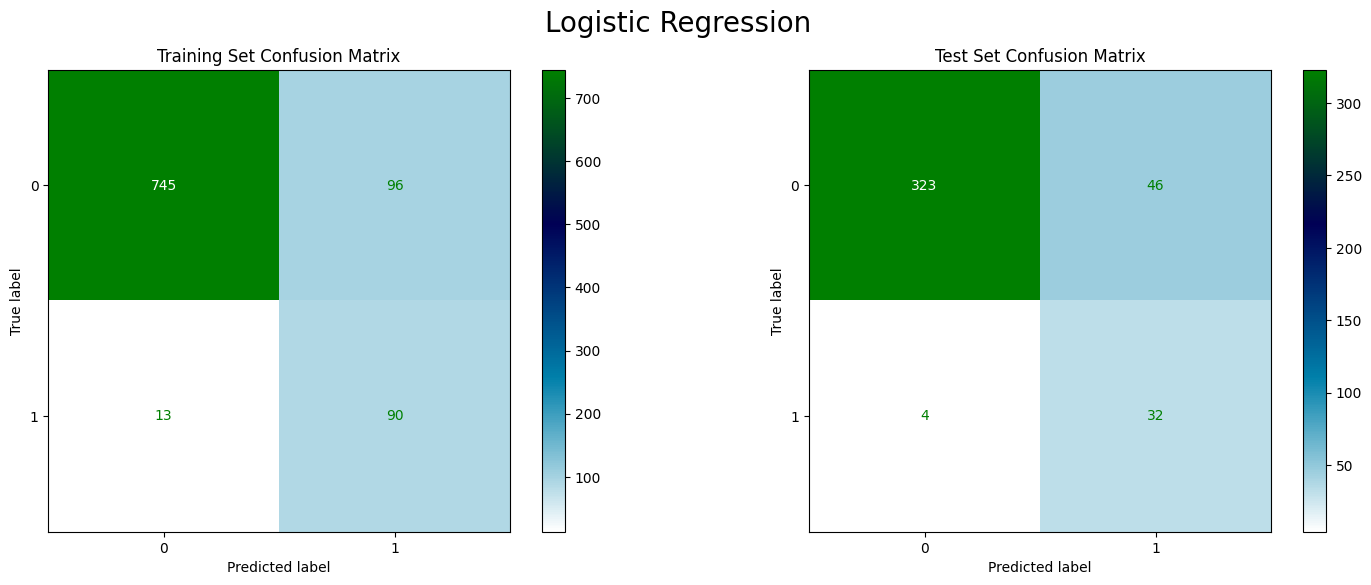

In [42]:
# Logistic Regression Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18,6))
ConfusionMatrixDisplay.from_estimator(lr_final, X_train, y_train, ax=axes[0], cmap='ocean_r')
axes[0].set_title('Training Set Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(lr_final, X_test, y_test, ax=axes[1], cmap='ocean_r')
axes[1].set_title('Test Set Confusion Matrix')
plt.suptitle('Logistic Regression', fontsize=20)
plt.show()



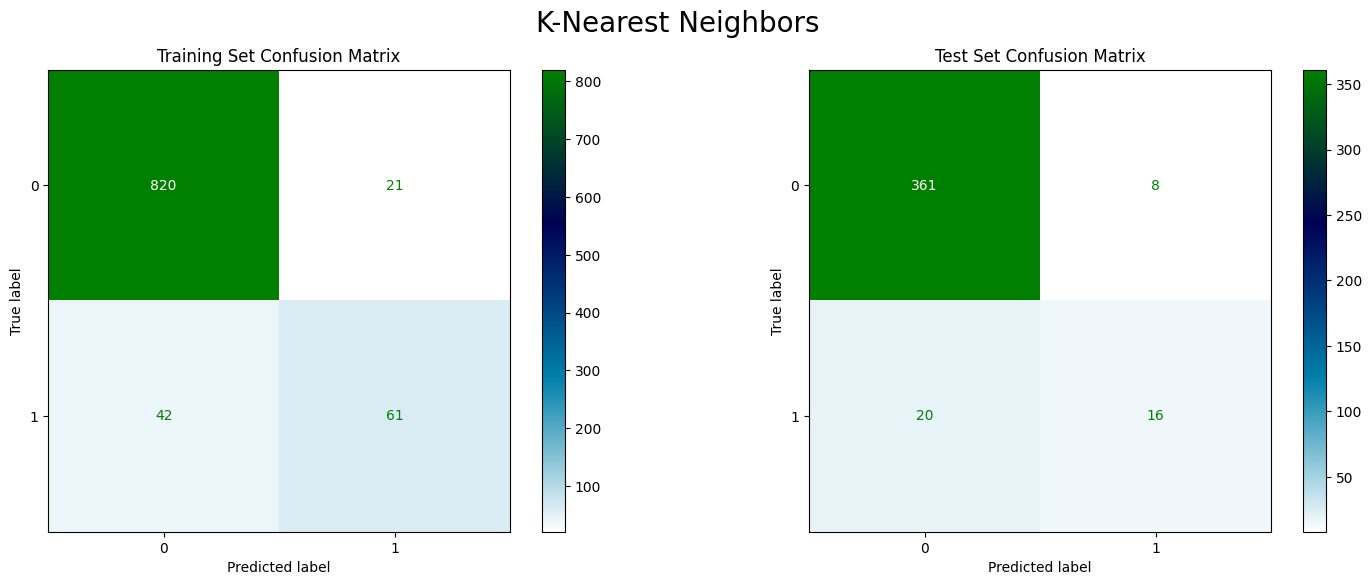

In [43]:
# K-Nearest Neighbors Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18,6))
ConfusionMatrixDisplay.from_estimator(knn_final, X_train, y_train, ax=axes[0], cmap='ocean_r')
axes[0].set_title('Training Set Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(knn_final, X_test, y_test, ax=axes[1], cmap='ocean_r')
axes[1].set_title('Test Set Confusion Matrix')
plt.suptitle('K-Nearest Neighbors', fontsize=20)
plt.show()


### Feature Importance

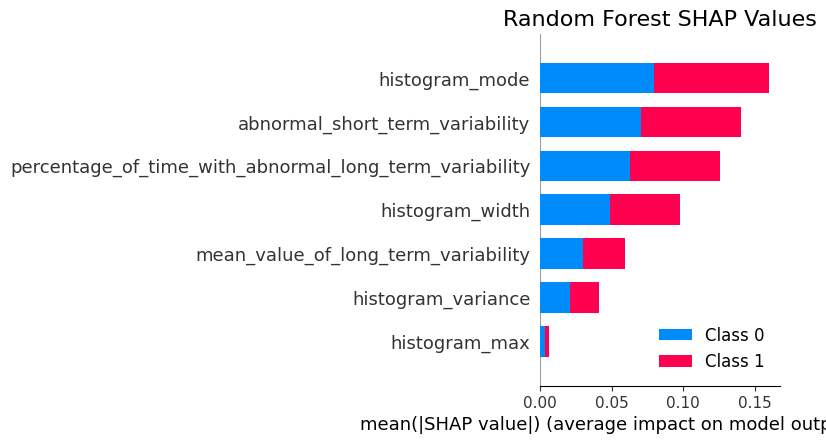

In [44]:
# Random Forest 
rf_explainer = shap.TreeExplainer(rf_final)
rf_shap_values = rf_explainer.shap_values(X_train, approximate=True)
fig = plt.figure(figsize=(15,10))
shap.summary_plot(rf_shap_values, features=X_train, feature_names=principal_components, plot_type='bar', show=False)
plt.title('Random Forest SHAP Values', fontsize=16)
plt.show()


In [45]:
# Logistic Regression
lr_coeff = pd.DataFrame(zip(principal_components, lr_final.coef_[0].transpose()), columns=['principal_component','coefficient'])
lr_coeff.sort_values(by=['coefficient'], ascending=False, inplace=True)
lr_coeff


,principal_component,coefficient
5,percentage_of_time_with_abnormal_long_term_var...,0.099880
2,abnormal_short_term_variability,0.091389
1,histogram_mode,0.059395
0,histogram_width,-0.017843
3,histogram_max,-0.032745
4,histogram_variance,-0.049697
6,mean_value_of_long_term_variability,-0.113501


## Conclusion

In our efforts to compare Random Forest, Logistic Regression, and K-Nearest Neighbors in predicting normal vs. abnormal CTG results, we found Random Forest was the best model. Furthermore, CTG fetal heart rate histogram mode, abnormal short-term variability, and percentage of time with long-term variability were the most influential features. Tuning for recall increased the number of false positives, decreasing the overall accuracy. A high number of outliers significantly decreased our sample size, and we recommend gathering additional CTGs readings to determine if a larger sample would improve results.

## References

* Ayres-de-Campos, D., Bernardes, J., Garrido, A., Marques-de-Sá, J., & Pereira-Leite, L. (2000). SisPorto 2.0: A Program for Automated Analysis of Cardiotocograms. The Journal of Maternal-Fetal Medicine. 9(5), 311-318. https://doi.org/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9

* Prior, L., & Lees, C. (2019). Control and Monitoring of Fetal Growth. Encyclopedia of Endocrine Diseases (Second Edition). https://www.sciencedirect.com/topics/nursing-and-health-professions/cardiotocograph

* Potter, L. (2021, November 12). How to Read a CTG. Geeky Medics. https://geekymedics.com/how-to-read-a-ctg/
